In [ ]:
#| default_exp spd

# EA SPD 

> Connect and interface with the public online files

In [ ]:
#| hide
from nbdev.showdoc import *

In [2]:
#| export
import pandas as pd
import numpy as np
import httpx
import json
import calendar
import datetime
import lxml
import asyncio
import re
from zipfile import ZipFile
from io import BytesIO
from io import StringIO

Call the EA website based on `year` to get available files

In [3]:
#| export
def _date(x):
    ''' Parse the filename to return file date '''
    tmp = re.search(r'(\d{1,2})111(\d{4})(\d{2})', x).groups()
    return f'{tmp[0]}/{tmp[2]}/{tmp[1]}'    

def extract_spd_list(year): 
    ''' Get list of available downloads from the casefiles '''
    return (pd.read_html(f'https://www.emi.ea.govt.nz/Wholesale/Datasets/DispatchAndPricing/Pre1November2022Archive/CaseFiles/{year}')[0] 
            .assign(file_date = lambda df_: pd.to_datetime(df_.Name.apply(_date), dayfirst=True)+ pd.DateOffset(days=1),
                    file_size = lambda df_: (df_['File size'].str.replace(',', '').str[:-3]).astype(int))
            .pipe(lambda df_: df_.loc[df_.file_size > 1000].drop_duplicates(subset=['file_date']))
            .set_index('file_date')
            .sort_index()
            )

In [7]:
extract_spd_list(2022)

,Name,Date modified,File size,file_size
file_date,,,,
2022-01-01,MSS_311112021121100996_0X.ZIP,03 Nov 2022,"6,380 KB",6380
2022-01-02,MSS_11112022011100274_0X.ZIP,03 Nov 2022,"6,426 KB",6426
2022-01-03,MSS_21112022011100481_0X.ZIP,03 Nov 2022,"6,457 KB",6457
2022-01-04,MSS_31112022011100206_0X.ZIP,03 Nov 2022,"6,458 KB",6458
2022-01-05,MSS_41112022011100952_0X.ZIP,03 Nov 2022,"6,453 KB",6453
...,...,...,...,...
2022-10-27,MSS_261112022101100331_0X.ZIP,03 Nov 2022,"6,309 KB",6309
2022-10-28,MSS_271112022101100130_0X.ZIP,03 Nov 2022,"6,303 KB",6303
2022-10-29,MSS_281112022101100927_0X.ZIP,03 Nov 2022,"6,266 KB",6266


In [5]:
#| export
def _branch(file):
    ''' Get raw spd files and return as dataframe for branches '''
    df = pd.concat((pd.DataFrame(_extract(file, fn, 'SOLUTION,BRANCH')[1:], 
                                    columns = _extract(file, fn, 'SOLUTION,BRANCH')[0])
                        for fn in file.namelist() if '.SPDSOLVED' in fn[-10:]), axis=0)
    cols = ['INTERVAL', 'BRANCHNAME', 'FROM_STATION', 'TO_STATION', 'FROM_MW', 'TO_MW', 'BRANCHLOSSES']
    return (df
        [cols]
        .assign(INTERVAL = lambda df_: pd.to_datetime(df_.INTERVAL.replace({';':':'}, regex=True),  dayfirst = True),
                TO_STATION = lambda df_: df_.TO_STATION.str.strip(),
                FROM_STATION = lambda df_: df_.FROM_STATION.str.strip(),
                FROM_MW = lambda df_: df_.FROM_MW.astype('float32'),
                TO_MW = lambda df_: df_.TO_MW.astype('float32'),
                BRANCHLOSSES = lambda df_: df_.BRANCHLOSSES.astype('float32'),
                ))

def _bus(file):
    ''' Get raw spd files and return as dataframe for bus '''
    df = pd.concat((pd.DataFrame(_extract(file, fn, 'SOLUTION,BUS')[1:], 
                                    columns = _extract(file, fn, 'SOLUTION,BUS')[0])
                        for fn in file.namelist() if '.SPDSOLVED' in fn[-10:]), axis=0)
    cols = ['INTERVAL', 'ID_BUS', 'ID_ST', 'LOAD', 'GENERATION']
    return (df
        [cols]
        .assign(INTERVAL = lambda df_: pd.to_datetime(df_.INTERVAL.replace({';':':'}, regex=True),  dayfirst = True),
                ID_BUS = lambda df_: df_.ID_BUS.str.strip(),
                ID_ST = lambda df_: df_.ID_ST.str.strip(),
                LOAD = lambda df_: df_.LOAD.astype('float32'),
                GENERATION = lambda df_: df_.GENERATION.astype('float32')
                ))

def _extract(file, fn, text):
    ''' parse zip file '''
    lines_to_keep = []
    with file.open(fn) as f:
        for line in f.readlines():
            if text in line.decode('utf8'):
                lines_to_keep.append(line.decode('utf8').replace('\n','').replace('\r','').split(','))
    return lines_to_keep

Test operation with one day

In [6]:
available_days = extract_spd_list(2022)

In [15]:
zip_file = httpx.get(f'https://www.emi.ea.govt.nz/Wholesale/Datasets/DispatchAndPricing/Pre1November2022Archive/CaseFiles/2022/{available_days.iloc[0].Name}', follow_redirects=True)
file = ZipFile(BytesIO(zip_file.content))
_bus(file)

,INTERVAL,ID_BUS,ID_ST,LOAD,GENERATION
0,2022-01-01 00:00:00,100,MVE,0.000000,0.0000
1,2022-01-01 00:00:00,101,MVE,0.000000,0.0000
2,2022-01-01 00:00:00,102,RTO,0.000000,0.0000
3,2022-01-01 00:00:00,103,CBG,19.943001,0.0000
4,2022-01-01 00:00:00,104,CBG,0.000000,0.0000
...,...,...,...,...,...
939,2022-01-01 23:30:00,95,ARI,0.000000,4.9120
940,2022-01-01 23:30:00,96,ARI,0.000000,15.3333
941,2022-01-01 23:30:00,97,ARI,0.000000,15.3333
942,2022-01-01 23:30:00,98,ARI,0.000000,15.3333


Want to speed up downloads - use httpx async

In [7]:
#| export
async def get_spd(client, url):
    res = await client.get(url, follow_redirects=True)
    return _branch(ZipFile(BytesIO(res.content))), _bus(ZipFile(BytesIO(res.content)))

async def main_spd(spd_df, year):
    # print(year)
    async with httpx.AsyncClient(timeout=None) as client:
        tasks = []
        for file_name in spd_df.Name.to_list():
            url = f'https://www.emi.ea.govt.nz/Wholesale/Datasets/DispatchAndPricing/Pre1November2022Archive/CaseFiles/{year}/{file_name}'
            tasks.append(asyncio.create_task(get_spd(client, url)))
        res = await asyncio.gather(*tasks)
        return pd.concat([x[0] for x in res]), pd.concat([x[1] for x in res])

Connect and download a month at a time

In [16]:
import sqlite3

connection = sqlite3.connect("bus.db")

In [8]:
month, year = 6, 2022
spd_df = extract_spd_list(year)
branch, bus = await main_spd(spd_df.loc[f'{year}-{month}'], year)

In [23]:
import altair as alt


In [54]:
tmp = (branch.assign(losses = lambda df_: df_.FROM_MW - df_.TO_MW, flow = lambda df_: abs(df_.FROM_MW)))
# .groupby('INTERVAL').agg({'losses':'sum','flow':'sum'}).reset_index()
# .assign(pc = lambda df_: df_.losses/df_.flow)).set_index('INTERVAL')#.pipe(lambda df_: alt.Chart(df_).mark_line().encode(x='INTERVAL:T', y='losses:Q'))

In [64]:
tmp_b =bus.groupby('INTERVAL').agg({'LOAD':'sum','GENERATION':'sum'}).reset_index().assign(losses = lambda df_: df_.GENERATION - df_.LOAD, pc = lambda df_: 100*df_.losses/df_.GENERATION ).set_index('INTERVAL')#.pipe(lambda df_: alt.Chart(df_).mark_line().encode(x='INTERVAL:T', y='pc:Q'))

Text(0.5, 0.98, 'Generation and Losses')

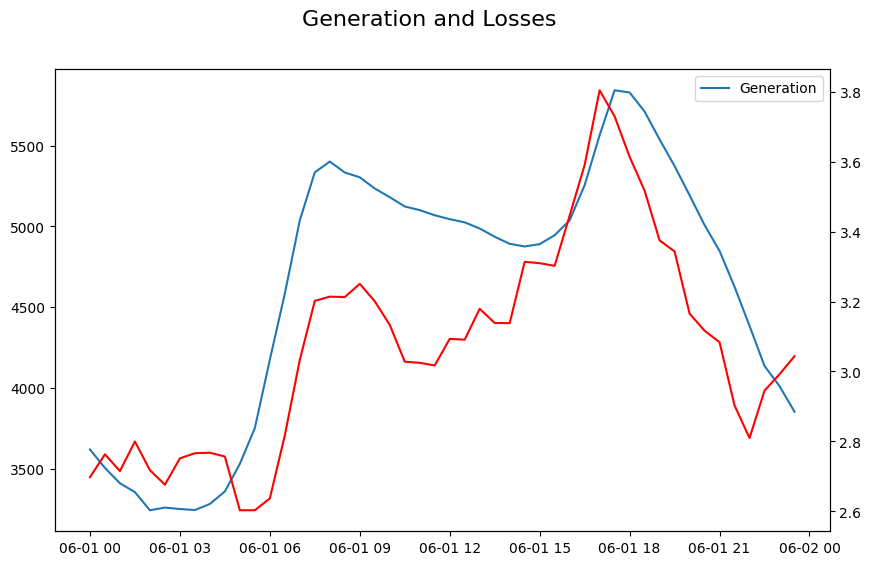

In [77]:
tmp_ = tmp_b.loc['2022-06-01']

fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(tmp.index, tmp.losses)
ax.plot(tmp_.index, tmp_.GENERATION)
ax.legend(['Generation'])
ax2 = ax.twinx()
ax2.plot(tmp_.index, tmp_.pc, color='red')
# ax2.legend(['Percent Losses'])
fig.suptitle('Generation and Losses', fontsize=16)

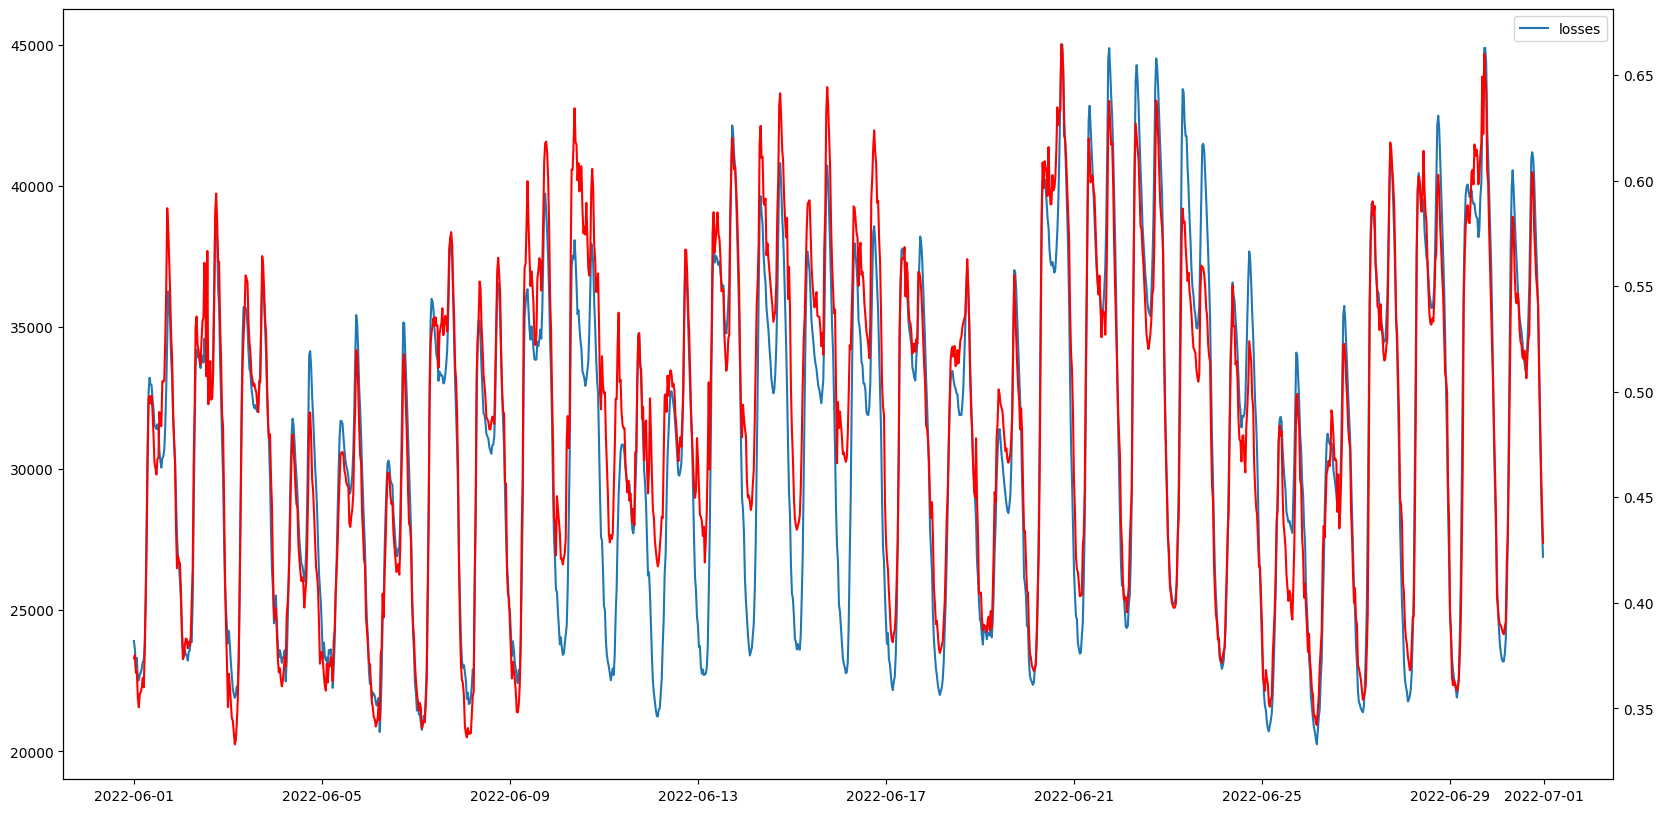

In [51]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(tmp.index, tmp.losses)
ax.plot(tmp.index, tmp.flow)
ax.legend(['losses', 'flow', 'pc'])
ax2 = ax.twinx()
ax2.plot(tmp.index, tmp.pc, color='red')


In [20]:
tmp = (branch.assign(FROM_MW = lambda df_: abs(df_.FROM_MW),
hour = lambda df_: df_.INTERVAL.dt.hour,
                losses = lambda df_: 100*(df_.BRANCHLOSSES/abs(df_.FROM_MW)).fillna(0))
        .pipe(lambda df_: df_[df_.FROM_MW >10])
        .groupby(['INTERVAL'])
        .agg({'FROM_MW':'sum','BRANCHLOSSES':'sum','hour':'first'})
                .assign(pc = lambda df_: 100*df_.BRANCHLOSSES/df_.FROM_MW)
        # .sort_values('losses', ascending=False)
        )

In [10]:
tmp = (branch.assign(FROM_MW = lambda df_: abs(df_.FROM_MW),
                    hour = lambda df_: df_.INTERVAL.dt.hour)
        .groupby(['INTERVAL'])
        .agg({'FROM_MW':'sum','BRANCHLOSSES':'sum','hour':'first'})
        .assign(pc = lambda df_: df_.BRANCHLOSSES/df_.FROM_MW)
        .reset_index())#.pipe(lambda df_: alt.Chart(df_).mark_line().encode(
# groupby('INTERVAL').BRANCHLOSSES.sum().reset_index()#.pipe(lambda df_: alt.Chart(df_).mark_line().encode(x='INTERVAL:Q',    y='BRANCHLOSSES:Q'))

<AxesSubplot: xlabel='hour', ylabel='pc'>

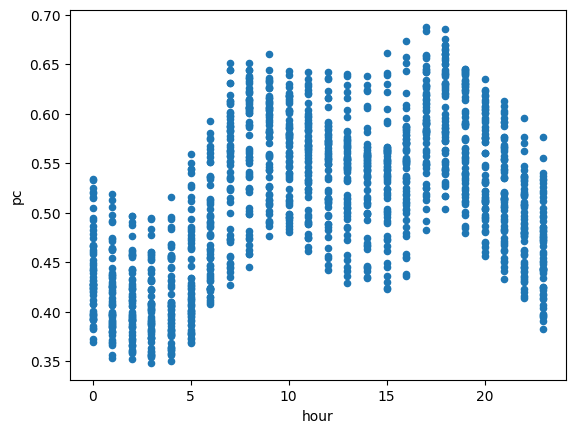

In [21]:
# tmp.plot(x='hour', y='BRANCHLOSSES', kind='scatter')
tmp.plot(x='hour', y='pc', kind='scatter')

In [ ]:
alt.Chart(url).mark_point().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q'
)